In [118]:
import networkx as nx
# Built-in libraries
import os
import sys
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm
from datetime import datetime, timedelta
from PIL import Image, ImageDraw, ImageFont

# Makerspace libraries
if os.path.isfile('./makerspace.py'): from makerspace import *
#
# else: from helpers.makerspace import *


##############
# timestamps #
##############

def return_unix_time(curr_time, scale=1000):
    ''' converts a string value into a unix timestamp (millisecond) 
        this code works for the following formats:
            - 2022-03-05 12:42:40.133000-05:00
            - 2022-03-23T14:59:56.533Z '''
    if 'T' in curr_time: curr_time = curr_time.replace('T', ' ')
    if 'Z' in curr_time: curr_time = curr_time.replace('Z', '')
    if '-05:00' in curr_time: curr_time = curr_time.replace('-05:00', '') 
    try:    
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S.%f")
        return int(curr_time.timestamp() * scale)
    except Exception as e:
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S")
        return int(curr_time.timestamp() * scale)

def add_unix_time_to_df(df, scale='millisecond'): 
    ''' add a column  that represents the unix time of a dataframe '''
    multiplier = 1
    if scale == 'millisecond': multiplier = 1000
    df['unix'] = df.apply(lambda x: return_unix_time(x['timestamp'],scale=multiplier), axis=1)

def which_hour(curr_time):
    ''' converts a string value into a unix timestamp (millisecond) 
        this code works for the following formats:
            - 2022-03-05 12:42:40.133000-05:00
            - 2022-03-23T14:59:56.533Z '''
    if 'T' in curr_time: curr_time = curr_time.replace('T', ' ')
    if 'Z' in curr_time: curr_time = curr_time.replace('Z', '')
    if '-05:00' in curr_time: curr_time = curr_time.replace('-05:00', '') 
    try:    
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S.%f")
        return curr_time.hour
    except Exception as e:
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S")
        return curr_time.hour

def add_hour_to_df(df):
    df['hour'] = df.apply(lambda x: which_hour(x['timestamp']), axis=1)

def convert_datetime(time_str):
  time_zone = time_str.split('-')[-1]
  time_zone = time_zone.split(':')[0] + time_zone.split(':')[1]
  time_date = time_str.split(' ')[0]
  time_time = time_str.split(' ')[1].split('-')[0]
  reformat_time = '{} {} -{}'.format(time_date,time_time,time_zone)

  try:
    return datetime.strptime(reformat_time, '%Y-%m-%d %H:%M:%S.%f %z')
  except:
    return datetime.strptime(reformat_time, '%Y-%m-%d %H:%M:%S %z')

def obtain_target_times(in_df_student,in_every_sec_freq):
  
  # obtain starting df_freq
  df_freq = in_df_student.copy()
  df_freq.sort_values(by=['timestamp'],inplace=True)
  df_freq.reset_index(inplace=True,drop=True)

  # obtain start_time, end_time and first target_time
  start_time = df_freq.at[0,'timestamp']
  end_time = df_freq.at[len(df_freq)-1,'timestamp']
  target_time = start_time + timedelta(seconds=in_every_sec_freq)

  # obtain target_times
  target_times = [start_time]

  def determine_time_diff(input_time):
    return (input_time - target_time).total_seconds()

  while target_time < end_time:
    df_freq['time_diff'] = df_freq['timestamp'].apply(determine_time_diff)
    df_freq = df_freq[df_freq['time_diff']>=0]
    potential_time = df_freq.at[df_freq['time_diff'].idxmin(),'timestamp']
    if (potential_time - target_time).total_seconds() < in_every_sec_freq:
      target_times.append(potential_time)
    
    target_time = target_time + timedelta(seconds=in_every_sec_freq)

  return target_times

############
# calendar #
############

def add_events(df, cohort): 
    ''' indicate when we had office hours or lab sections '''
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
    df['office'] = df['datetime'].apply(lambda x: cohort.is_office(x))
    df['section'] = df['datetime'].apply(lambda x: cohort.is_section(x))


########################
# Self-touch behaviors #
########################

def add_self_touch(df, threshold=0.1):
    ''' creates a new column called "self_touch" that indicates if the person
        touched his/her face with his/her hand (1) or not (0) for each row '''
    
    df['self_touch'] = df.apply(lambda x: min(
         dist_two_points_3d((x['nose_x'],x['nose_y'],x['nose_z']), 
                            (x['left_wrist_x'],x['left_wrist_y'],x['left_wrist_z'])), 
         dist_two_points_3d((x['nose_x'],x['nose_y'],x['nose_z']), 
                            (x['right_wrist_x'],x['right_wrist_y'],x['right_wrist_z']))), 
    axis=1)
    
    df['self_touch'] = df['self_touch'].apply(lambda x: 1 if x <= threshold else '')


############
# Movement #
############

def add_movement(df, threshold=5, verbose=False):
    
    # assumes that most people won't be moving
    df['is_moving'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    nosex = df['nose_x'].to_numpy()
    nosey = df['nose_y'].to_numpy()
    time = df['datetime']

    # go through the data
    #for i in range(0,df.shape[0]-1):
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([nosex[i],nosey[i]]).any(): continue
        nose = transform_coordinates(nosex[i],nosey[i])

        # check if this person exists
        if person in positions.keys():
            prev_nose = positions[person][1]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points(nose,prev_nose)
                df.at[i,'move_dist'] = dist
                if dist < threshold: df.at[i,'is_moving'] = 1

        # update the last seen position
        positions[person] = (curr_time,nose)

        # print progress
        if i % 10000 == 0 and verbose:
            sys.stdout.write("\r")
            sys.stdout.write(str(i) + "/"+str(df.shape[0]))
            sys.stdout.flush()

        
def add_joint_movement(df, joint):
    
    # assumes that most people won't be moving
    df[joint+'_movement'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    joint_x = df[joint+'_x'].to_numpy()
    joint_y = df[joint+'_y'].to_numpy()
    joint_z = df[joint+'_z'].to_numpy()
    time = df['datetime']

    # go through the data
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([joint_x[i],joint_y[i]]).any(): continue
        jointxyz = joint_x[i],joint_y[i],joint_z[i]

        # check if this person exists
        if person in positions.keys():
            prev_joint = positions[person][1]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points_3d(jointxyz,prev_joint) * 90
                df.at[i,joint+'_movement'] = dist

        # update the last seen position
        positions[person] = (curr_time,jointxyz)
       


            
def add_two_joints_movement(df, joint1, joint2):
    
    # find joint name
    joint_name = joint1.replace('right_','').replace('left_','')
    df[joint_name+'_movement'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    lx,ly,lz = df[joint1+'_x'].to_numpy(),df[joint1+'_y'].to_numpy(),df[joint1+'_z'].to_numpy()
    rx,ry,rz = df[joint2+'_x'].to_numpy(),df[joint2+'_y'].to_numpy(),df[joint2+'_z'].to_numpy()
    time = df['datetime']

    # go through the data
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([lx[i],ly[i],lz[i],rx[i],ry[i],rz[i]]).any(): continue
        l = lx[i],ly[i],lz[i]
        r = rx[i],ry[i],rz[i]

        # check if this person exists
        if person in positions.keys():
            prev_l,prev_r = positions[person][1],positions[person][2]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points_3d(l,prev_l)+dist_two_points(r,prev_r)
                df.at[i,joint_name+'_movement'] = dist * 90

        # update the last seen position
        positions[person] = (curr_time,l,r)
    
        
########################
# social Interactions  #
########################

def add_social_interactions(df, threshold=100, verbose=False):
    ''' add two columns: 'is_with', which indicates someone that the person is close to;
        and 'is_oriented_toward', which indicates someone who is close and where 
        their lines of sight (orthogonal from shoulders to nose) intersect'''

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    lshoulderx = df['left_shoulder_x'].to_numpy()
    lshouldery = df['left_shoulder_y'].to_numpy()
    rshoulderx = df['right_shoulder_x'].to_numpy()
    rshouldery = df['right_shoulder_y'].to_numpy()
    nosex = df['nose_x'].to_numpy()
    nosey = df['nose_y'].to_numpy()
    time = df['datetime'].to_numpy()

    # go through the data
    for i in range(0,df.shape[0]-1):

        # get the data
        t = time[i]
        if np.isnan([nosex[i],nosey[i]]).any(): continue
        hx = (lshoulderx[i]+rshoulderx[i])/2.0
        hy = (lshouldery[i]+rshouldery[i])/2.0
        head = transform_coordinates(hx,hy)
        nose = transform_coordinates(nosex[i],nosey[i])

        # check the next entries
        j = i+1
        while(time[j] == time[i] and j < df.shape[0]-1):

            # check if we have data
            if not np.isnan([nosex[j],nosey[j]]).any(): 
                nosej = transform_coordinates(nosex[j],nosey[j])
                
                # close proximity
                if dist_two_points(nose,nosej) < threshold: 
                    
                    # create a column to keep track of the other person
                    df.at[i,'is_with'] = persons[j]

                    # check body orientation
                    hxj = (lshoulderx[j]+rshoulderx[j])/2.0
                    hyj = (lshouldery[j]+rshouldery[j])/2.0
                    headj = transform_coordinates(hxj,hyj)
                    gaze1 = compute_gaze(head,nose)
                    gaze2 = compute_gaze(headj,nosej)
                    if intersect(gaze1,gaze2) != None: 
                        df.at[i,'is_oriented_toward'] = persons[j]

                    
            # check the next row
            j += 1

        # print progress
        if i % 10000 == 0 and verbose:
            sys.stdout.write("\r")
            sys.stdout.write(str(i) + "/"+str(df.shape[0]))
            sys.stdout.flush()
            
#Removes Rows with certain values (like unidentified)
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [119]:
from matplotlib.colors import ListedColormap
#next(Data, None)  # skip the first line in the input file
#Data Import
#dat = pd.read_csv('2022-01-27-features.csv')

# Get CSV files list from a folder
path = 'data_folder'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
dat   = pd.concat(df_list, ignore_index=True)




C:\Users\louis\AppData\Local\Temp\ipykernel_2712\866862961.py:12: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2712\866862961.py:12: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2712\866862961.py:12: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2712\866862961.py:12: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2712\866862961.py:12: DtypeWarning: Columns (14,15,16) have 

In [120]:
dat[['Date', 'Time']] = dat['datetime'].str.split(' ', expand=True, regex=False)
print(dat)


#Weekframes:
#dat['Date'] = dat['Date'].apply(pd.to_datetime)
#print('done convert')
#weeks = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='W', dropna=True))]

        person_identity             datetime            aoi  is_moving  \
0                  rhea  2022-01-27 09:00:01  collaboration        NaN   
1          unidentified  2022-01-27 09:00:01  collaboration        NaN   
2                  yani  2022-01-27 09:00:01  collaboration        NaN   
3               melissa  2022-01-27 09:00:01  collaboration        NaN   
4               natalie  2022-01-27 09:00:01  collaboration        NaN   
...                 ...                  ...            ...        ...   
6750996          conner  2022-05-05 02:00:01  collaboration        1.0   
6750997    unidentified  2022-05-05 02:00:01  collaboration        NaN   
6750998            rhea  2022-05-05 02:00:01  collaboration        NaN   
6750999            sara  2022-05-05 02:00:01          laser        NaN   
6751000            yani  2022-05-05 02:00:01  collaboration        1.0   

         move_dist  left_knee_angle  right_knee_angle  standing  \
0              NaN        53.483247         

In [121]:
#dat.info()
dat['Date'] = pd.to_datetime(dat['Date'])
#dat.info()
weeks = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='W', dropna=True))]

months = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='M', dropna=True))]

In [122]:
print(weeks[1])

       person_identity             datetime            aoi  is_moving  \
18270           daniel  2022-01-31 14:02:26  collaboration        NaN   
18271           daniel  2022-01-31 14:02:27        nothing        NaN   
18272           daniel  2022-01-31 14:02:28        nothing        NaN   
18273           daniel  2022-01-31 14:02:29        printer        NaN   
18274           daniel  2022-01-31 14:02:30        printer        NaN   
...                ...                  ...            ...        ...   
399762           ji su  2022-02-06 21:36:21        nothing        NaN   
399763           ji su  2022-02-06 21:36:22        nothing        NaN   
399764           ji su  2022-02-06 21:36:23        nothing        NaN   
399765           ji su  2022-02-06 21:36:24        nothing        NaN   
399766           ji su  2022-02-06 21:36:25        nothing        1.0   

         move_dist  left_knee_angle  right_knee_angle  standing  \
18270          NaN       165.543838        164.952711   

In [123]:
#Data Filtering
time_in_mks_dat = dat
time_in_mks_dat = time_in_mks_dat[time_in_mks_dat.person_identity != 'unidentified']
time_in_mks_dat = time_in_mks_dat.groupby(['person_identity']).size().reset_index(name='time_in_mks')
#print(time_in_mks_dat)
filtered_dat = dat[dat.is_oriented_toward != 'unidentified']
filtered_dat = filtered_dat[filtered_dat.person_identity != 'unidentified']
filtered_dat = filtered_dat[filtered_dat.person_identity != filtered_dat.is_oriented_toward]
grouped_data=filtered_dat.groupby(['person_identity','is_oriented_toward']).size().reset_index(name='is_with_count')
grouped_data = grouped_data[grouped_data.is_with_count > 3]
grouped_data['is_with_count_ln2'] = np.log2(grouped_data['is_with_count'])

#print(grouped_data)


def datafilter(data):
    time_in_mks_dat = data
    time_in_mks_dat = time_in_mks_dat[time_in_mks_dat.person_identity != 'unidentified']
    time_in_mks_dat = time_in_mks_dat.groupby(['person_identity']).size().reset_index(name='time_in_mks')
    #print(time_in_mks_dat)
    data = data[data.is_oriented_toward != 'unidentified']
    data = data[data.person_identity != 'unidentified']
    data = data[data.person_identity != data.is_oriented_toward]
    grouped_data = data.groupby(['person_identity','is_oriented_toward']).size().reset_index(name='is_with_count')
    grouped_data = grouped_data.merge(time_in_mks_dat, left_on='person_identity', right_on='person_identity')
    #grouped_data = grouped_data[grouped_data.is_with_count > 3]
    print(grouped_data)
    return grouped_data

In [124]:
for week in weeks:
    week=datafilter(week)
    print(week, '\n', '\n')
    
filtered_weeks = [datafilter(week) for week in weeks]
print(filtered_weeks[1])

for all in filtered_weeks:
    for each in all:
        for each2 in all:
            print(each, each2[1])
            if (each == each2[1] and (each[1] == each2[0])):
                print(each(person_identity), each2(is_oriented_toward), each(is_with_count)-each2(is_with_count))
            
        

for month in months:
    month=datafilter(month)

filtered_months= [datafilter(month) for month in months]
    

  person_identity is_oriented_toward  is_with_count  time_in_mks
0           chali             daniel              1          425
  person_identity is_oriented_toward  is_with_count  time_in_mks
0           chali             daniel              1          425 
 

   person_identity is_oriented_toward  is_with_count  time_in_mks
0           aashna             daniel             48         7235
1           aashna               marc              6         7235
2           aashna             xiaoyi              1         7235
3             alaa              chali              8        20965
4             alaa             denise              6        20965
..             ...                ...            ...          ...
95            sara              helen             43        10325
96            sara              ji su             13        10325
97            sara               marc             18        10325
98            sara             rachel            139        10325
99        

In [125]:

def add_time_spent_to_group(Group, dataset):
    time_spent_dat1 = dataset.groupby(['person_identity'])['is_with_count'].sum().reset_index(name='time_spent')
    time_spent_dat2 = dataset.groupby(['is_oriented_toward'])['is_with_count'].sum().reset_index(name='time_spent')
    time_spent_dat2.rename(columns={'is_oriented_toward':'person_identity'}, inplace=True)
    time_spent_dat1.set_index('person_identity').to_dict()['time_spent']
    time_spent_dat2.set_index('person_identity').to_dict()['time_spent']
    time_spent_dat = pd.concat([time_spent_dat1, time_spent_dat2]).groupby(['person_identity'])['time_spent'].sum().reset_index(name='time_spent_with')
    
    time_in_mks_dat = dataset
    time_in_mks_dat = time_in_mks_dat.merge(time_spent_dat, left_on='person_identity', right_on='person_identity')
    time_in_mks_dat['pct_time_in_mks_with'] = time_in_mks_dat['time_spent_with']/time_in_mks_dat['time_in_mks']
    node_t_s_2 = time_in_mks_dat.set_index('person_identity').to_dict()['time_in_mks']
    #print("Time : ", node_t_s_2)
    nx.set_node_attributes(Group, node_t_s_2, 'time_in_mks')
    node_t_s = time_in_mks_dat.set_index('person_identity').to_dict()['pct_time_in_mks_with']
    #print("Nodes : ", node_t_s)
    #print("% : ", node_t_s)
    nx.set_node_attributes(Group, node_t_s, 'time_spent_with')
    return Group

def add_time_spent_in_mks_to_group(Group, dataset):
    time_spent_dat = dataset     
    node_t_s = time_spent_dat.set_index('person_identity').to_dict()['time_in_mks']
    #print("Nodes : ", node_t_s)
    nx.set_node_attributes(Group, node_t_s, 'time_in_mks')
    return Group

def dataplot(Group, name):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    tim_spent_with = []
    for all in Group.nodes():
        #print(all, " : ", Group.nodes[all])
        #if(Group.nodes[all].empty()):
        #    Group.remove_node(all)
        #else:
        tim_spent.append(nx.get_node_attributes(Group, 'time_in_mks')[all])
        tim_spent_with.append(nx.get_node_attributes(Group, 'time_spent_with')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    pos = nx.circular_layout(Group)# k=2, weight='is_with_count')
    print('edges: ', nx.number_of_edges(Group))
    print('nodes: ', nx.number_of_nodes(Group))
    if (nx.number_of_edges(Group) < 1):
        nx.draw(Group, node_size=[v for v in tim_spent ])
        return
    node_size_factor = 1000/max([v for v in tim_spent])
    width_size_factor = 10/(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    #print(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])), " vs : ", np.sqrt(np.average([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    nx.draw(Group, pos, node_size=[v*node_size_factor for v in tim_spent], 
            cmap = cmap, vmin = min([b for b in tim_spent_with]), vmax = max([b for b in tim_spent_with]), #min(btc.values()), vmax = max(btc.values()), 
            node_color=[b for b in tim_spent_with],#[b for b in btc.values()], 
            edge_cmap = cmap2, 
            edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, 
            edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), 
            edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]),
            width = [width_size_factor*np.sqrt(e[2]['is_with_count']) for e in Group.edges(data=True)])
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([b for b in tim_spent_with]),vmax=max([b for b in tim_spent_with])),cmap=cmap), extend='both', orientation='vertical', label = 'Time Spent With Others', ax=None)
    #cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')
    plt.savefig(name)
    

In [198]:
#Creating Overall Metrics Dataset
G_overall = nx.from_pandas_edgelist(grouped_data, 'person_identity', 'is_oriented_toward', ['is_with_count'])
nodelist = nx.nodes(G_overall)
print(nodelist)
df_nodes = pd.DataFrame(nodelist, columns=['person_identity'])
#df_nodes['week_number'] = 0
df_nodes.head()
#df_nodes.set_index('person_identity', inplace=True)
df_nodes_copy = df_nodes.copy()

#df_nodes_copy.set_index('person_identity', inplace=True)
print(df_nodes_copy)

['aashna', 'alaa', 'chali', 'conner', 'daniel', 'helen', 'hoa', 'iulian', 'juan', 'marc', 'melissa', 'miaoya', 'natalie', 'rachel', 'rhea', 'rui', 'sara', 'xiaoyi', 'yani', 'denise', 'ji su', 'rebecca', 'bertrand']
   person_identity
0           aashna
1             alaa
2            chali
3           conner
4           daniel
5            helen
6              hoa
7           iulian
8             juan
9             marc
10         melissa
11          miaoya
12         natalie
13          rachel
14            rhea
15             rui
16            sara
17          xiaoyi
18            yani
19          denise
20           ji su
21         rebecca
22        bertrand


In [218]:
def max_edge_weight_for_node(G, node):
    if(G.degree[node] == 0):
        return 0
    return max([e[2]['is_with_count'] for e in G.edges(node, data=True)])

Week :                   betweenness_centrality  degree  max_edge_weight  week_number
person_identity                                                              
aashna                         0.000000       1               54            2
daniel                         0.368908       5              156            2
marc                           0.040936       3              362            2
xiaoyi                         0.000000       0                0            2
alaa                           0.000000       2              257            2
chali                          0.148148       4              190            2
denise                         0.000000       2              215            2
helen                          0.010234       2               90            2
ji su                          0.002924       2               39            2
rachel                         0.161306       4              365            2
rebecca                        0.266082       4         

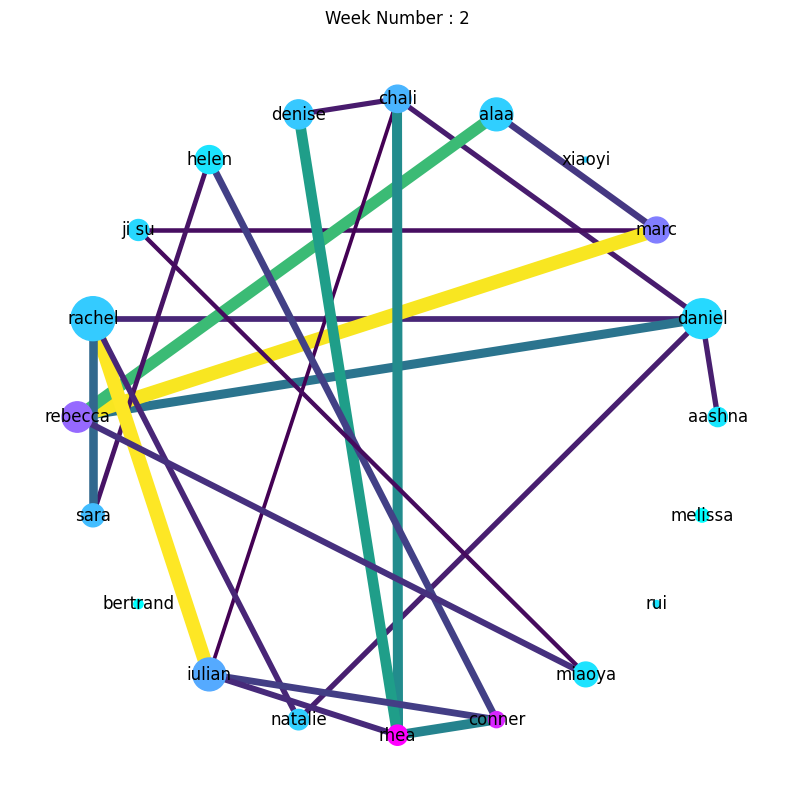

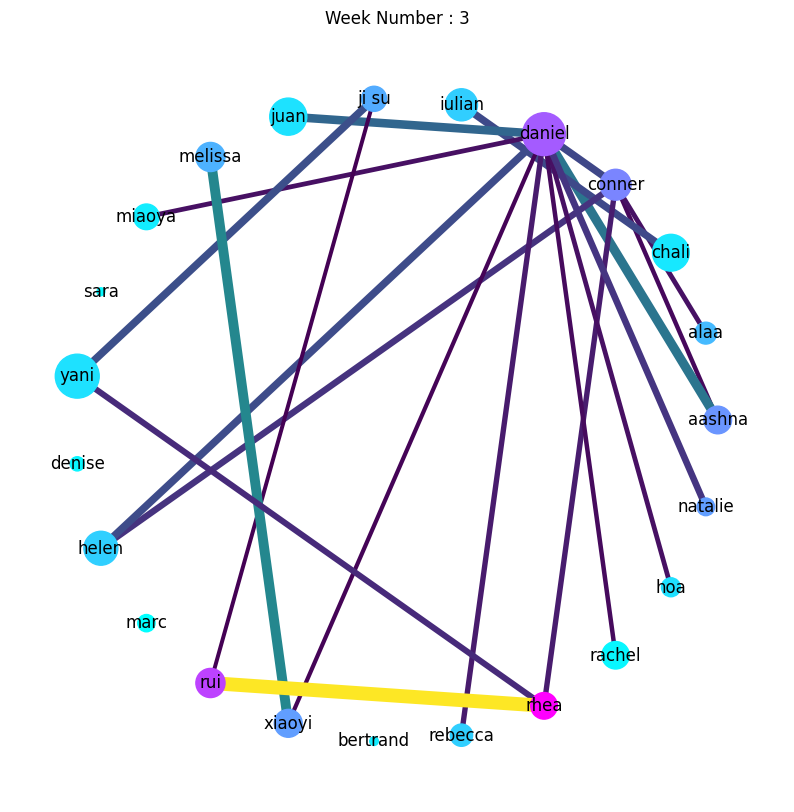

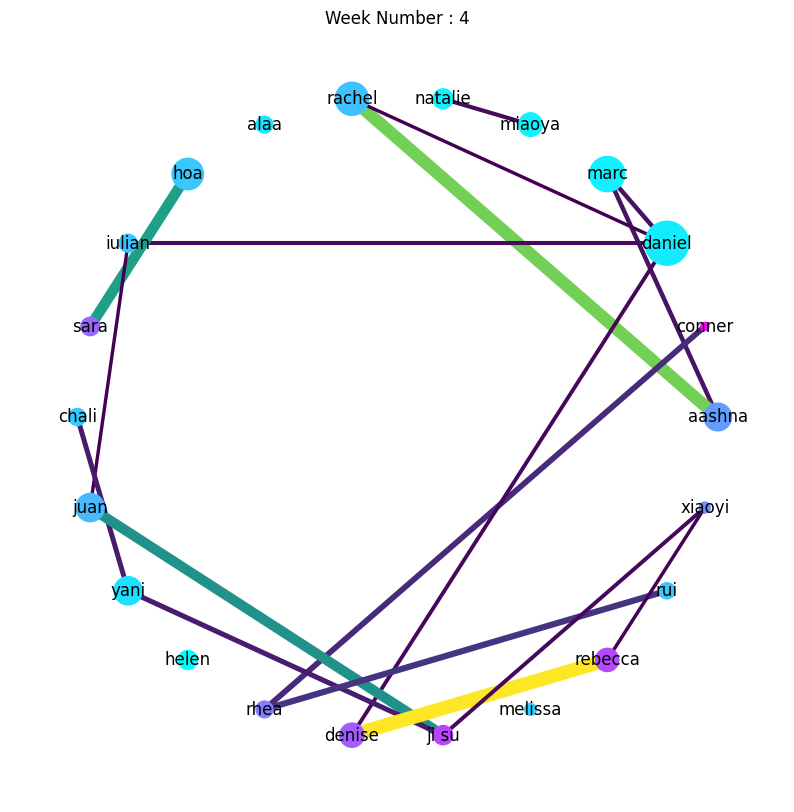

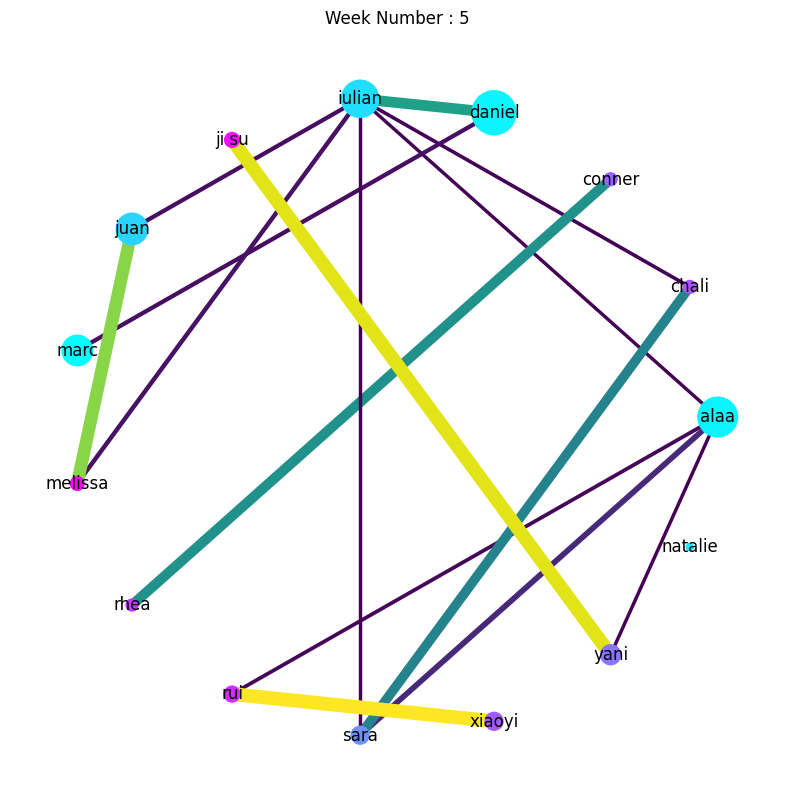

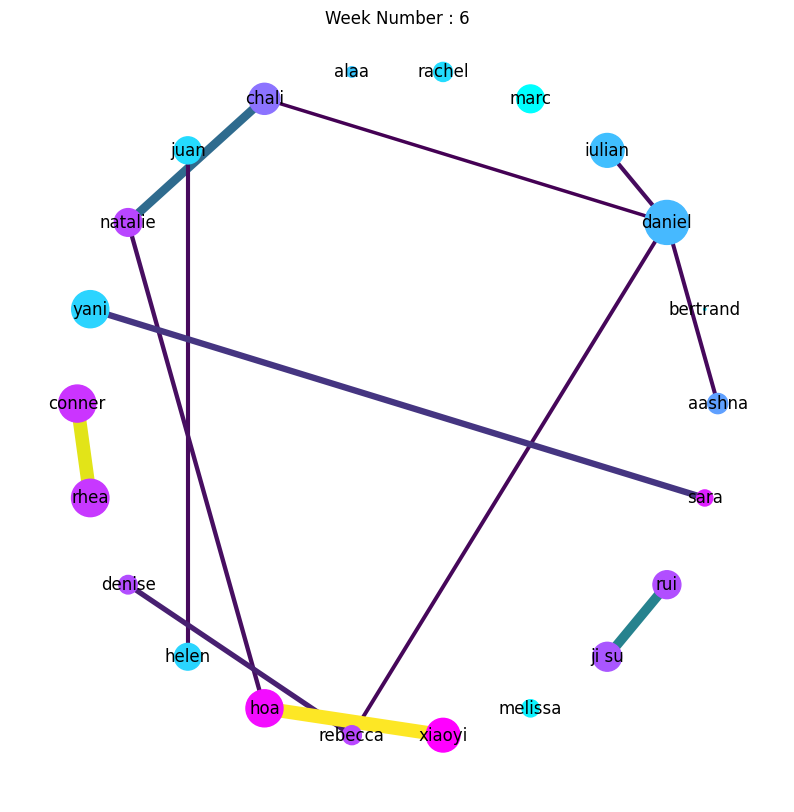

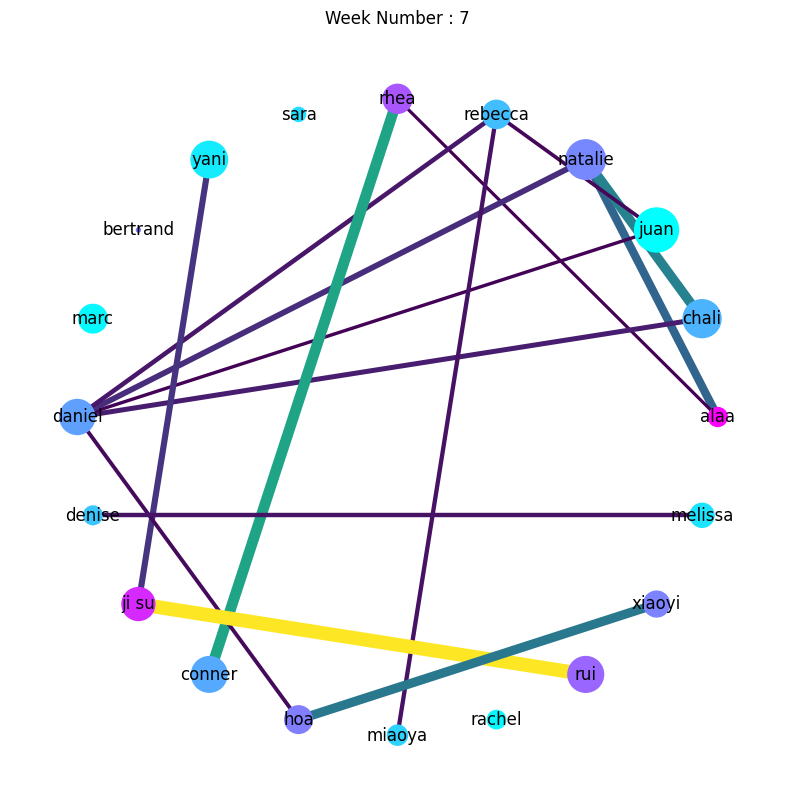

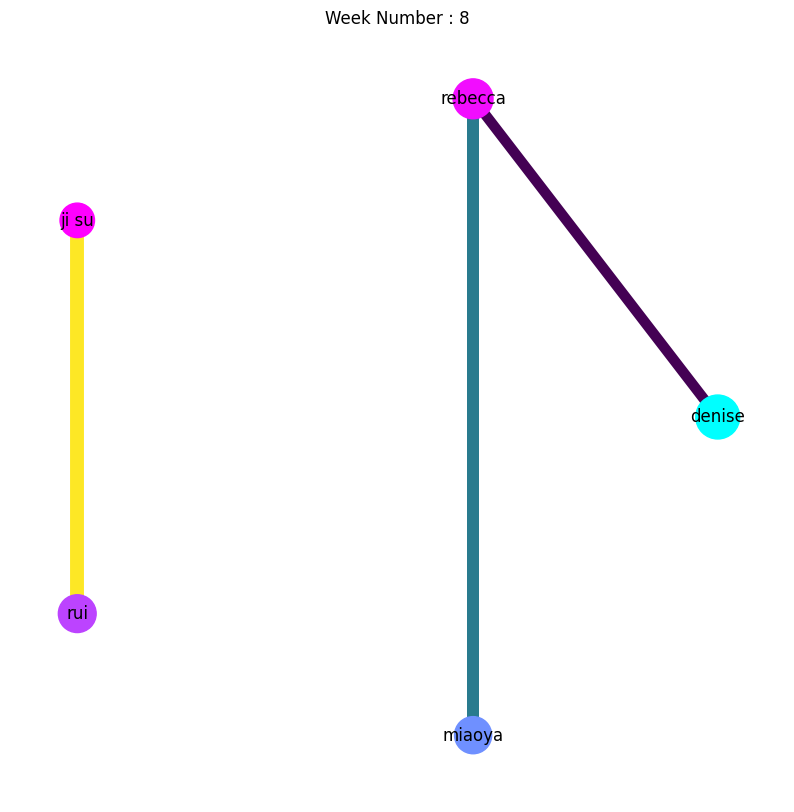

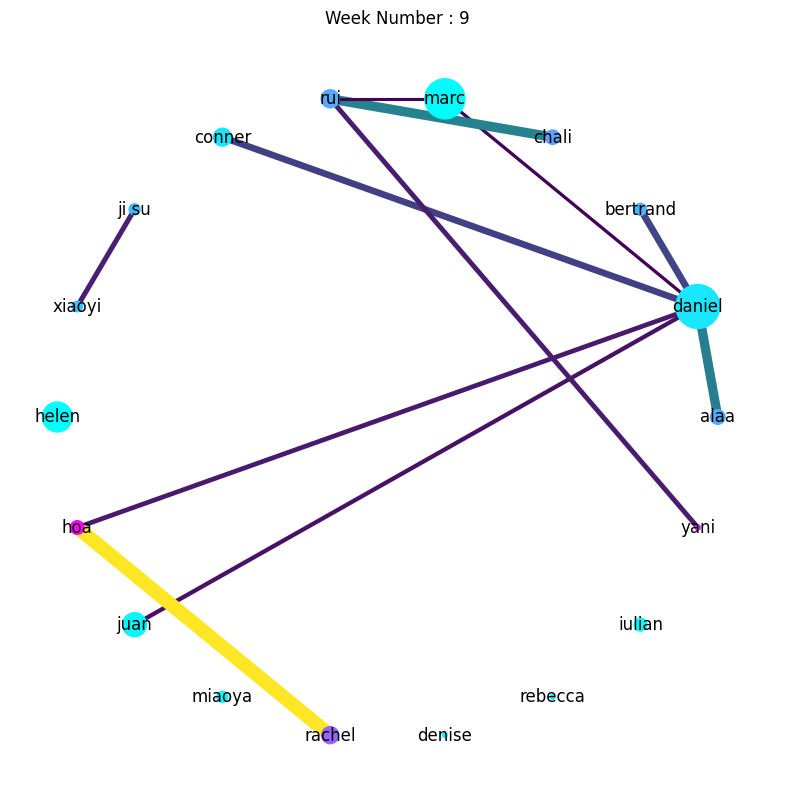

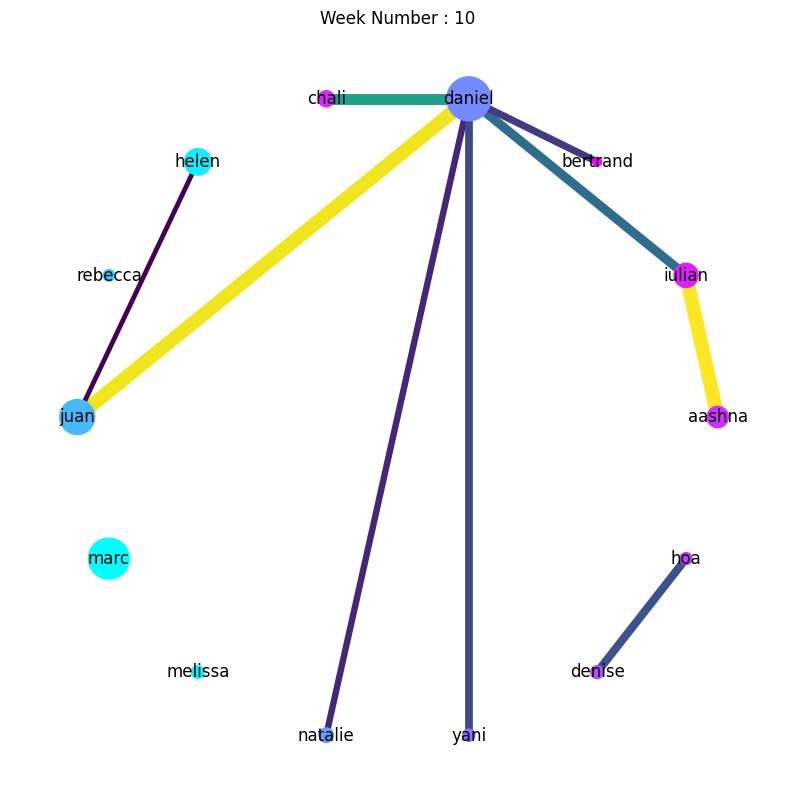

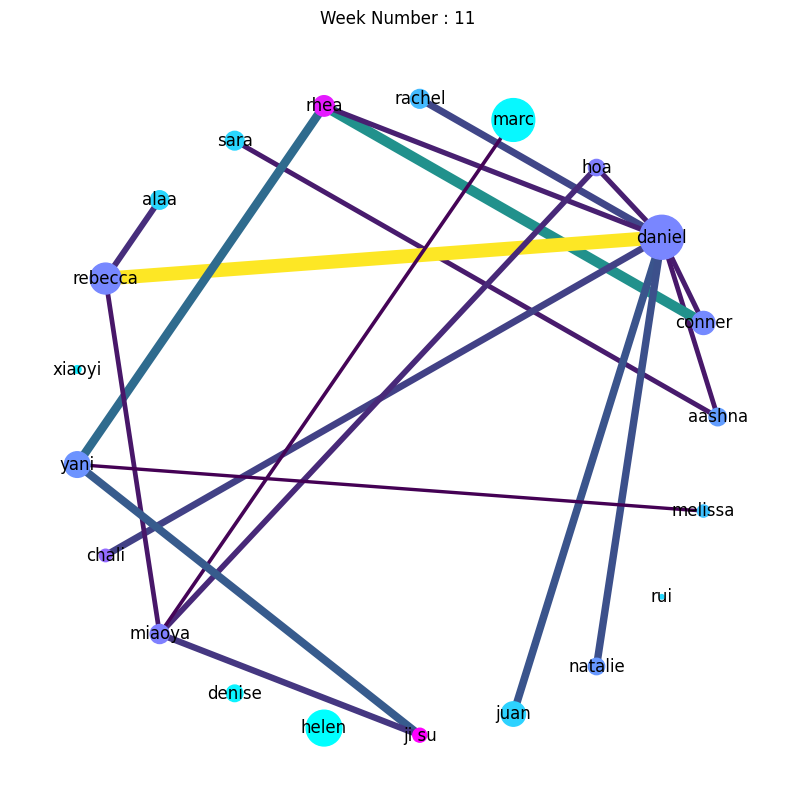

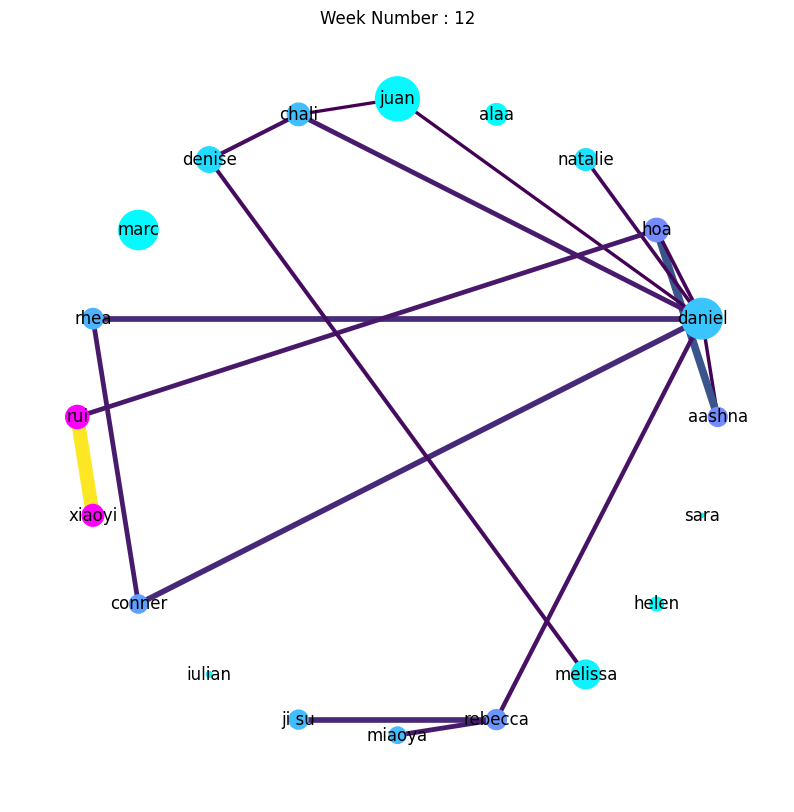

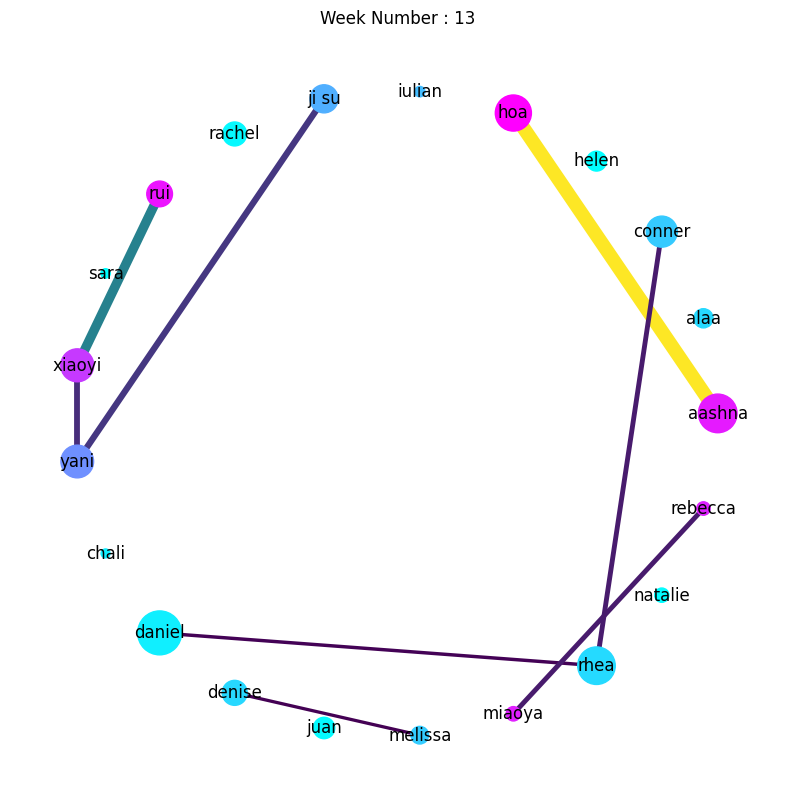

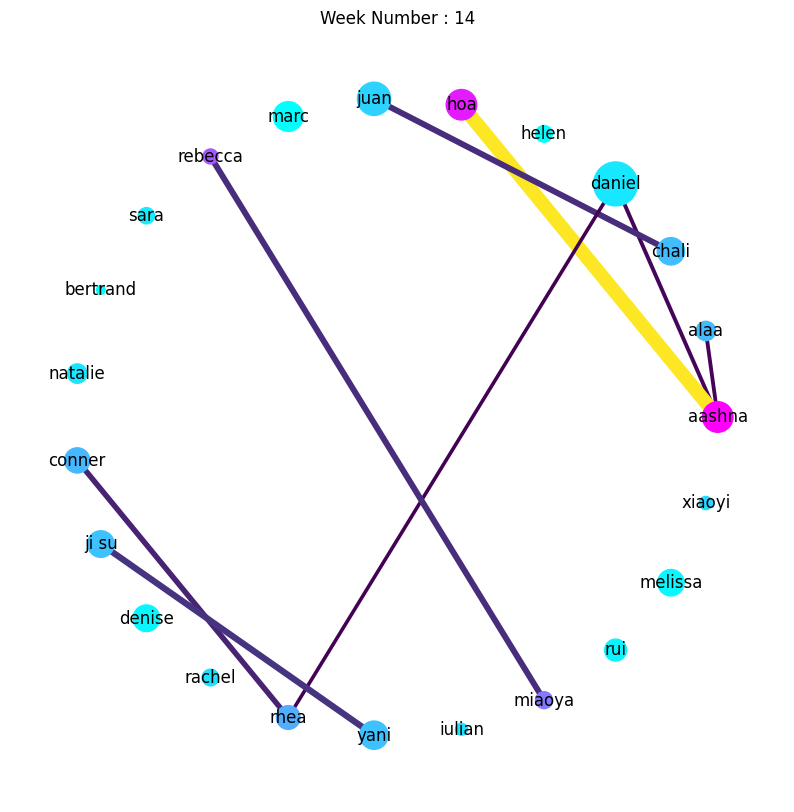

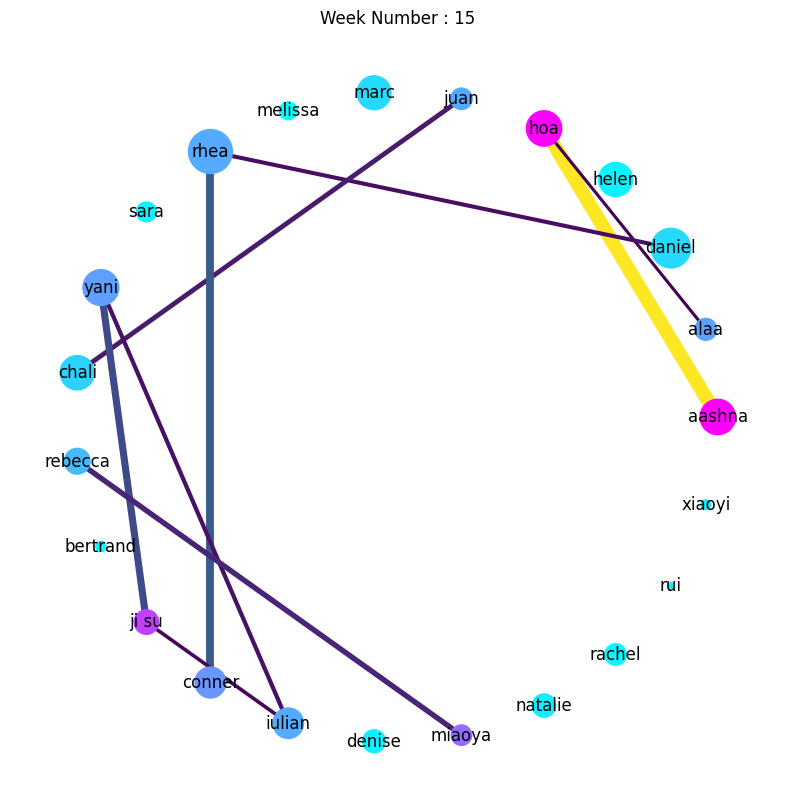

In [219]:
n = 0
check = 0
df_nodes = df_nodes_copy
for week in filtered_weeks:
    n=n+1
    if(n==1):
        continue
    if(week.empty):
        continue
    if(week.shape[0] < 3):
        continue
    #if(n > 3):
        #continue
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(week, create_using=Graphtype, source='person_identity', target='is_oriented_toward', edge_attr='is_with_count')
    max_count = max([e[2]['is_with_count'] for e in G.edges(data=True)])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['is_with_count'] <= 0.05*max_count]
    G.remove_edges_from(to_remove)
    G2 = add_time_spent_to_group(G, week)
    nodes_to_remove = []
    #nodes_to_remove = [n for n, attrs in G.nodes(data=True) if attrs['time_in_mks']<50]
    #print("Removing : ", nodes_to_remove)
    #G.remove_nodes_from(nodes_to_remove)
    tim_spent = []
    for all in G2.nodes(data='time_in_mks', default=0):
        if(all[1]==0):
            nodes_to_remove.append(all[0])
    G2.remove_nodes_from(nodes_to_remove)
    for all in nx.get_node_attributes(G2, 'time_spent_in_mks'):
        tim_spent.append(nx.get_node_attributes(G2, 'time_spent_in_mks')[all])
    tim_sp = nx.get_node_attributes(G2, 'time_spent_in_mks')
    if(nx.number_of_nodes(G2) < 2):
        continue
    #NETWORK MEASURES:
    #Week Number
    nx.set_node_attributes(G2, n, 'week_number')
    for node in G2.nodes():
        G2.nodes[node]['max_edge_weight'] = max_edge_weight_for_node(G2, node)
    
    #Betweenness Centrality
    btc = nx.betweenness_centrality(G2)
    nx.set_node_attributes(G2, btc, 'betweenness_centrality')
        
    #Degree Centrality
    degc = nx.degree_centrality(G2)
    nx.set_node_attributes(G2, degc, 'degree_centrality')
    
    #Degrees
    deg_list = dict(G2.degree())
    #print('Deg_list : ', deg_list)
    nx.set_node_attributes(G2, deg_list, 'degree')
    
    
    week_nodelist = nx.nodes(G2)
    #print(nx.get_node_attributes(G2, 'betweenness_centrality'))
    list_btc = list(btc.values())
    #print('Btc values : ', list_btc)
    #print('Week Nodelist : ', week_nodelist)
    dict_centrality = nx.get_node_attributes(G2, 'betweenness_centrality')
    dict_degree = nx.get_node_attributes(G2, 'degree')
    dict_degree_centrality = nx.get_node_attributes(G2, 'degree_centrality')
    dict_max_edge_weight = nx.get_node_attributes(G2, 'max_edge_weight')
    #print(dict_degree)
    df_weekly_ce = pd.DataFrame.from_dict(dict_centrality, orient='index', columns=['betweenness_centrality'])
    df_weekly_ce.rename_axis('person_identity', inplace=True)
    df_weekly_de = pd.DataFrame.from_dict(dict_degree, orient='index', columns=['degree'])
    df_weekly_de.rename_axis('person_identity', inplace=True)
    df_weekly_max_edge_weight = pd.DataFrame.from_dict(dict_max_edge_weight, orient='index', columns=['max_edge_weight'])
    df_weekly_max_edge_weight.rename_axis('person_identity', inplace=True)
    #df_weekly_de_ce = pd.DataFrame.from_dict(dict_degree_centrality, orient='index', columns=['degree_centrality'])
    #df_weekly_de_ce.head()
    
    df_weekly = df_weekly_ce.merge(df_weekly_de, left_on='person_identity', right_on='person_identity')
    df_weekly = df_weekly.merge(df_weekly_max_edge_weight, left_on='person_identity', right_on='person_identity')
    #df_weekly = df_weekly.merge(df_weekly_de_ce, left_on='person_identity', right_on='person_identity')
    df_weekly['week_number'] = n
    print("Week : ", df_weekly)

    df_weekly_join = df_nodes_copy
    df_weekly_join = df_weekly.join(df_weekly_join.set_index('person_identity'), on='person_identity', how='left')
    df_weekly_join.fillna(0, inplace=True)
    df_weekly_join['week_number'] = n
    df_weekly_join['betweenness_centrality'] = df_weekly_join['betweenness_centrality'].astype(float)
    df_weekly_join['degree'] = df_weekly_join['degree'].astype(float)
    df_weekly_join['max_edge_weight'] = df_weekly_join['max_edge_weight'].astype(float)
    print('Empty Joined: ', df_weekly_join)
    if(check==0):
        df_nodes = df_weekly_join
        check = 1
    else:
        df_nodes = pd.concat([df_nodes, df_weekly_join])
    plt.figure(figsize=(10,10))
    plt.title('Week Number : '+str(n))
    #print('Week Number : ', n)
    dataplot(G2, "Week Number : "+str(n))
    print('Added : ', df_nodes)

print('Overall : ', df_nodes)

In [220]:
print(df_nodes)
df_nodes.to_csv('nodes.csv')

                 betweenness_centrality  degree  max_edge_weight  week_number
person_identity                                                              
aashna                         0.000000     1.0             54.0            2
daniel                         0.368908     5.0            156.0            2
marc                           0.040936     3.0            362.0            2
xiaoyi                         0.000000     0.0              0.0            2
alaa                           0.000000     2.0            257.0            2
...                                 ...     ...              ...          ...
miaoya                         0.000000     1.0            770.0           15
natalie                        0.000000     0.0              0.0           15
rachel                         0.000000     0.0              0.0           15
rui                            0.000000     0.0              0.0           15
xiaoyi                         0.000000     0.0              0.0

In [221]:
df_nodes_analyzed = df_nodes.copy()
df_nodes_analyzed = df_nodes_analyzed.groupby(['person_identity']).mean().reset_index()
print(df_nodes_analyzed)

   person_identity  betweenness_centrality    degree  max_edge_weight  \
0           aashna                0.011163  1.600000      1800.000000   
1             alaa                0.037101  1.083333       241.750000   
2         bertrand                0.000000  0.250000        26.000000   
3            chali                0.027687  1.538462       515.076923   
4           conner                0.023779  1.666667       918.000000   
5           daniel                0.217239  4.846154       410.384615   
6           denise                0.009145  0.846154       317.230769   
7            helen                0.000930  0.545455        92.909091   
8              hoa                0.032247  1.636364      2042.545455   
9           iulian                0.056274  1.636364       228.272727   
10           ji su                0.011637  1.538462       951.307692   
11            juan                0.013828  1.333333       421.833333   
12            marc                0.018065  0.75000

11
edges:  8
nodes:  11
23
edges:  57
nodes:  23
23
edges:  19
nodes:  23
23
edges:  16
nodes:  23
23
edges:  11
nodes:  23


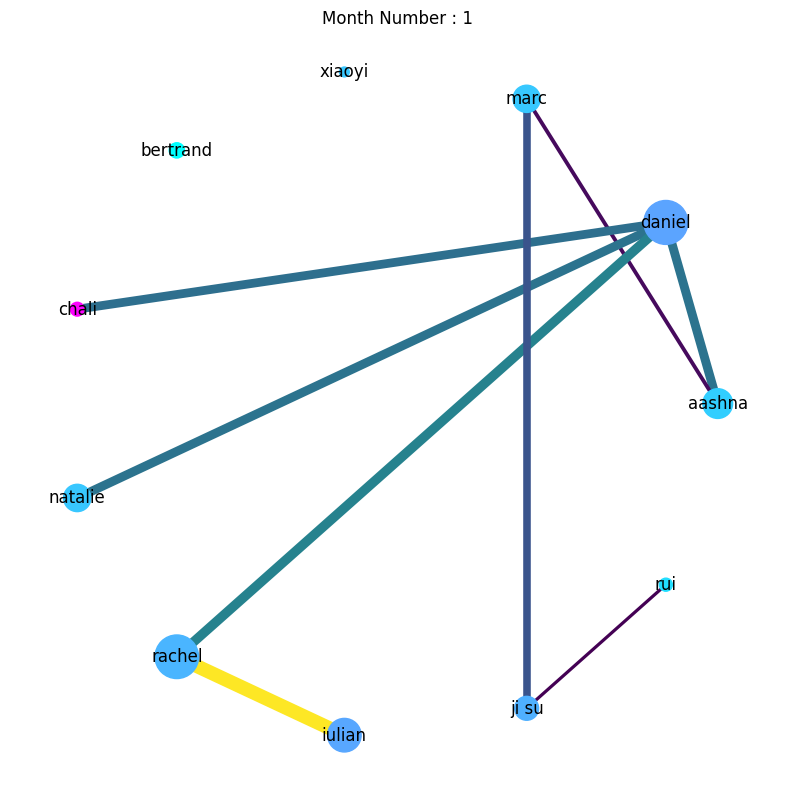

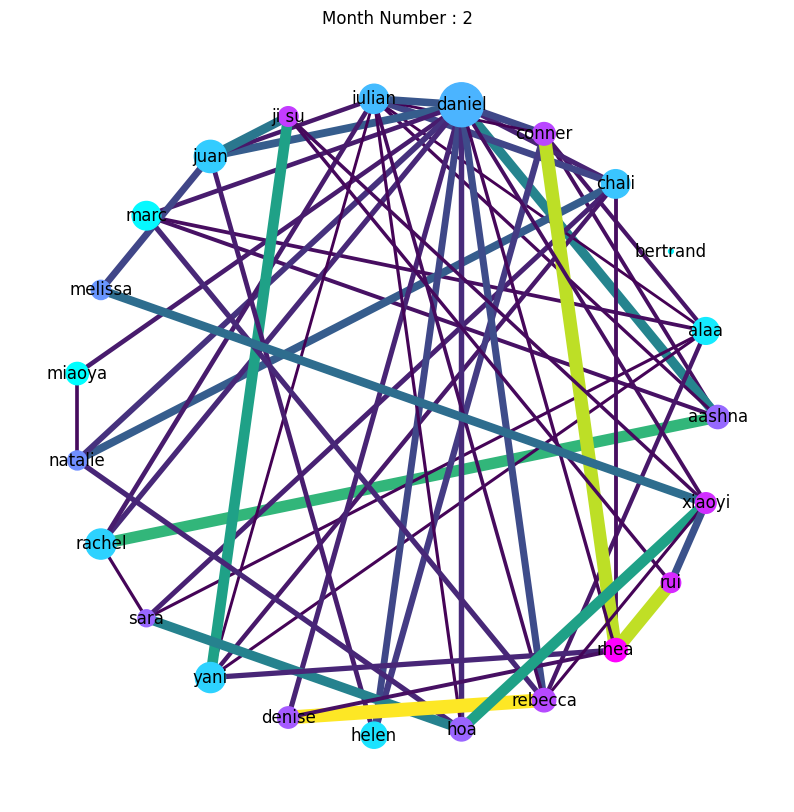

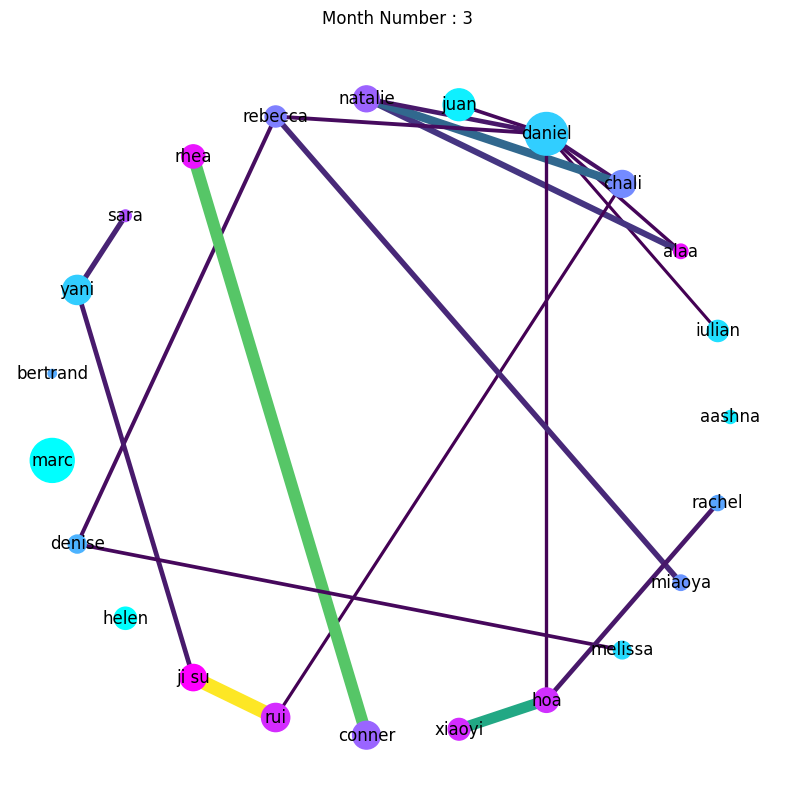

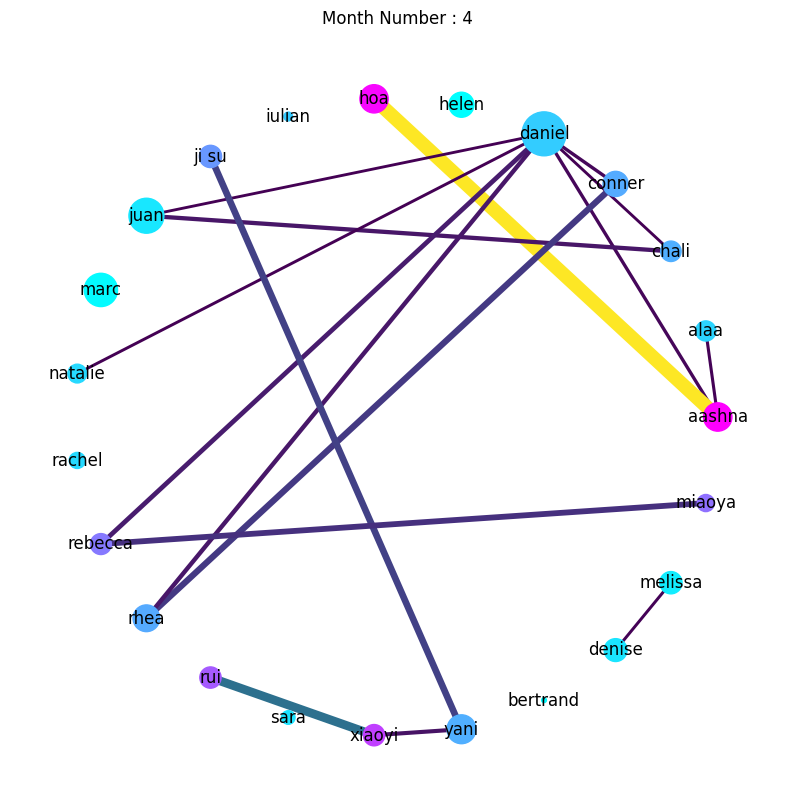

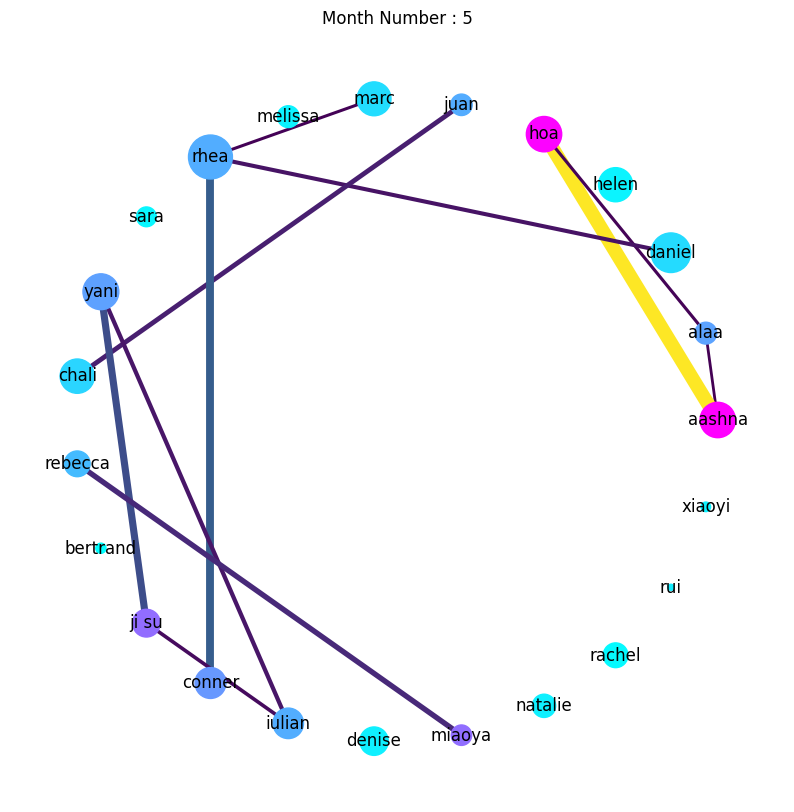

In [ ]:
n=0
for month in filtered_months:
    n=n+1
    if(month.empty):
        continue
    if(month.shape[0] < 3):
        continue
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(month, create_using=Graphtype, source='person_identity', target='is_oriented_toward', edge_attr='is_with_count')
    max_count = max([e[2]['is_with_count'] for e in G.edges(data=True)])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['is_with_count'] <= 0.04*max_count]
    G.remove_edges_from(to_remove)
    G2 = add_time_spent_to_group(G, month)
    #nodes_to_remove = [n for n, attrs in G.nodes(data=True) if attrs['time_spent_in_mks']<100]
    #print("Removing : ", nodes_to_remove)
    #G.remove_nodes_from(nodes_to_remove)
    tim_spent = []
    for all in nx.get_node_attributes(G2, 'time_spent_in_mks'):
        tim_spent.append(nx.get_node_attributes(G2, 'time_spent_in_mks')[all])
    tim_sp = nx.get_node_attributes(G2, 'time_spent_in_mks')
    if(nx.number_of_nodes(G2) < 2):
        continue
    print(nx.number_of_nodes(G2))
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    dataplot(G2, "Month Number : "+str(n))

In [ ]:
def dataplot_pos(Group, name, pos):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    tim_spent_with = []
    for all in Group.nodes():
        #print(all, " : ", Group.nodes[all])
        #if(Group.nodes[all].empty()):
        #    Group.remove_node(all)
        #else:
        tim_spent.append(nx.get_node_attributes(Group, 'time_in_mks')[all])
        tim_spent_with.append(nx.get_node_attributes(Group, 'time_spent_with')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    print('edges: ', nx.number_of_edges(Group))
    print('nodes: ', nx.number_of_nodes(Group))
    if (nx.number_of_edges(Group) < 1):
        nx.draw(Group, node_size=[v for v in tim_spent ])
        return
    node_size_factor = 1000/max([v for v in tim_spent])
    width_size_factor = 10/(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    #print(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])), " vs : ", np.sqrt(np.average([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    nx.draw(Group, pos, node_size=[v*node_size_factor for v in tim_spent], 
            cmap = cmap, vmin = min([b for b in tim_spent_with]), vmax = max([b for b in tim_spent_with]), #min(btc.values()), vmax = max(btc.values()), 
            node_color=[b for b in tim_spent_with],#[b for b in btc.values()], 
            edge_cmap = cmap2, 
            edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, 
            edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), 
            edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]),
            width = [width_size_factor*np.sqrt(e[2]['is_with_count']) for e in Group.edges(data=True)])
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([b for b in tim_spent_with]),vmax=max([b for b in tim_spent_with])),cmap=cmap), extend='both', orientation='vertical', label = 'Time Spent With Others', ax=None)
    #cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')
    plt.savefig(name)

23
edges:  19
nodes:  23
edges:  19
nodes:  23
edges:  19
nodes:  23
edges:  19
nodes:  23


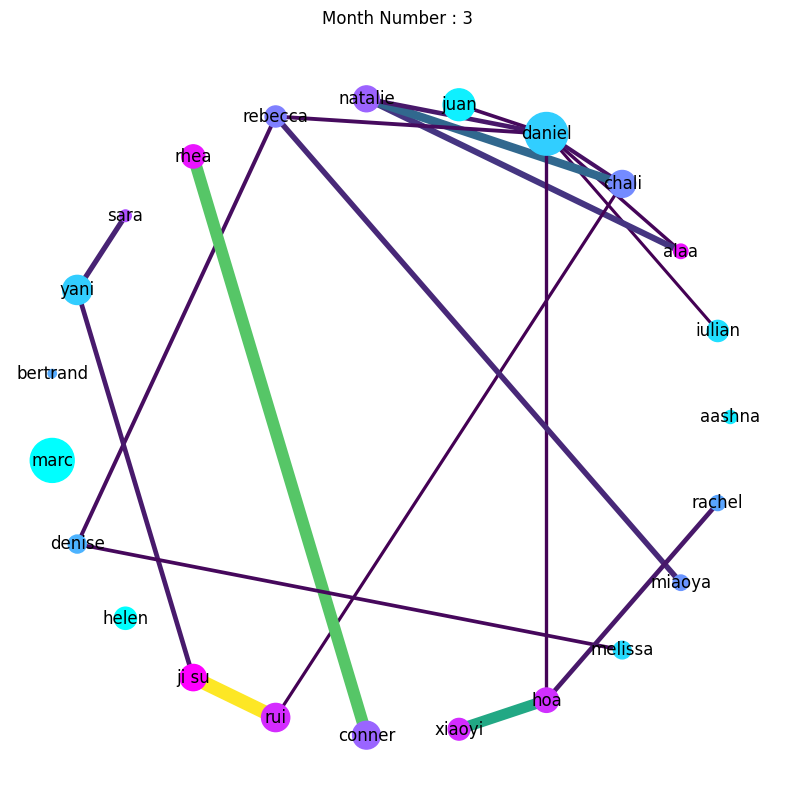

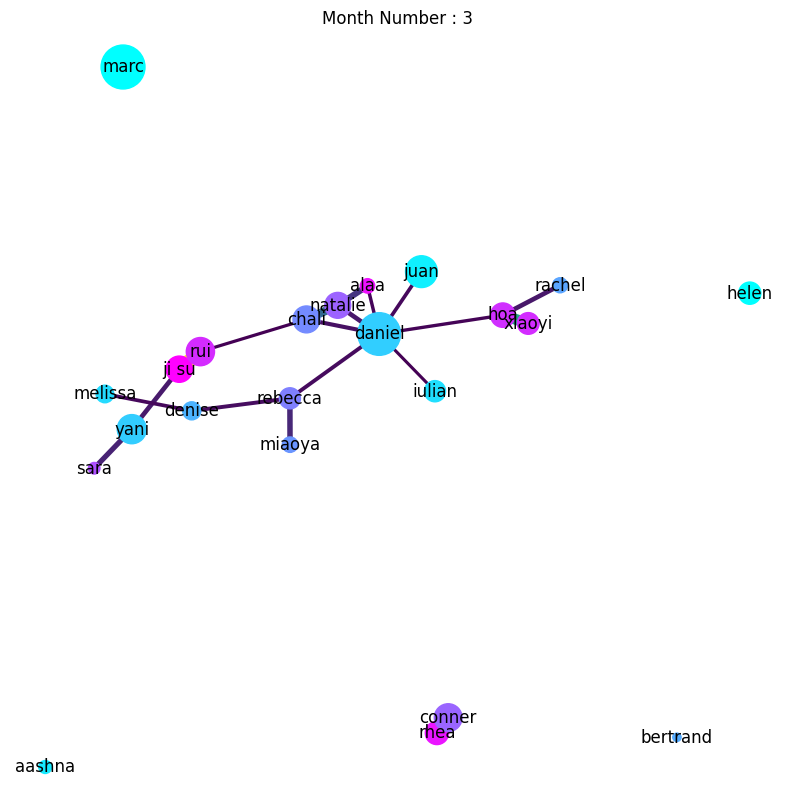

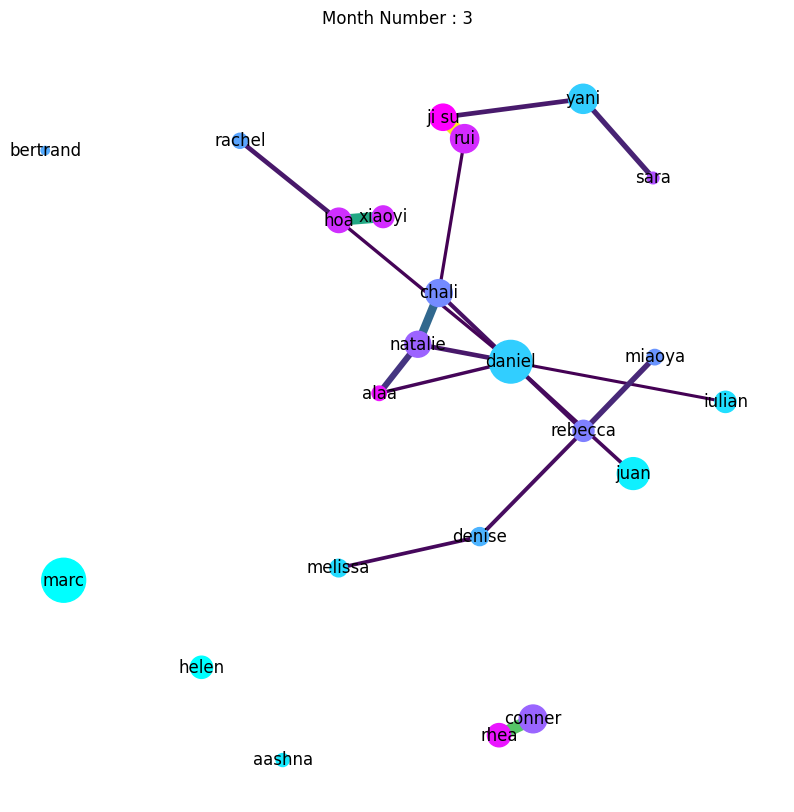

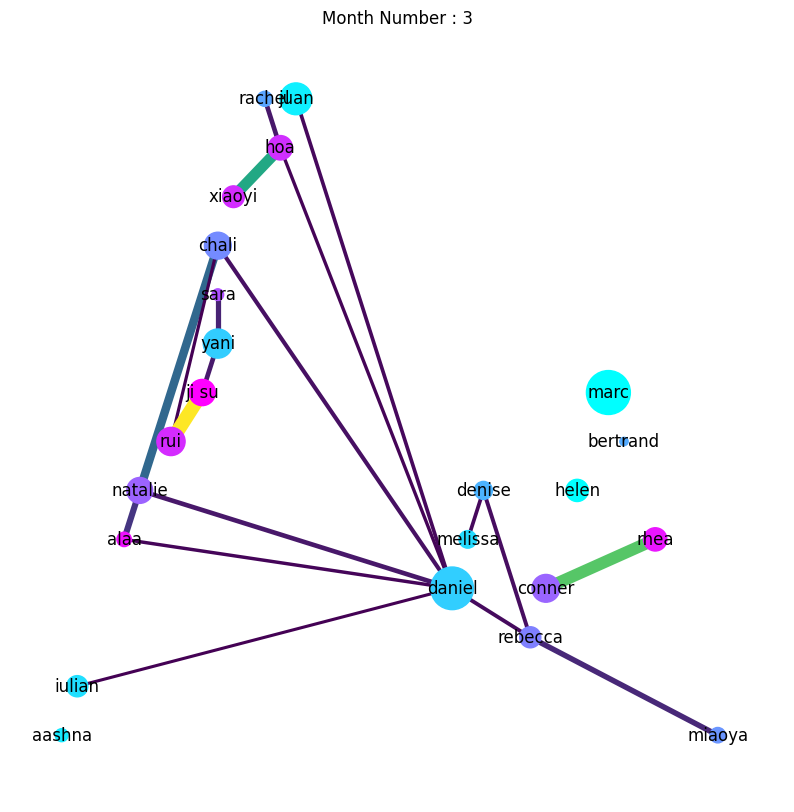

In [ ]:
n=0
for month in filtered_months:
    n=n+1
    if(month.empty):
        continue
    if(month.shape[0] < 3):
        continue
    if(n!=3):
        continue
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(month, create_using=Graphtype, source='person_identity', target='is_oriented_toward', edge_attr='is_with_count')
    max_count = max([e[2]['is_with_count'] for e in G.edges(data=True)])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['is_with_count'] <= 0.04*max_count]
    G.remove_edges_from(to_remove)
    G2 = add_time_spent_to_group(G, month)
    #nodes_to_remove = [n for n, attrs in G.nodes(data=True) if attrs['time_spent_in_mks']<100]
    #print("Removing : ", nodes_to_remove)
    #G.remove_nodes_from(nodes_to_remove)
    tim_spent = []
    for all in nx.get_node_attributes(G2, 'time_spent_in_mks'):
        tim_spent.append(nx.get_node_attributes(G2, 'time_spent_in_mks')[all])
    tim_sp = nx.get_node_attributes(G2, 'time_spent_in_mks')
    if(nx.number_of_nodes(G2) < 2):
        continue
    print(nx.number_of_nodes(G2))
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    pos = nx.circular_layout(G2)
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    pos = nx.spring_layout(G2, k=2, weight='is_with_count')
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))    
    pos = nx.spring_layout(G2, k=4, weight='is_with_count')
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))    
    pos = nx.planar_layout(G2)
    dataplot_pos(G2, "Month Number : "+str(n), pos)

In [ ]:
base_path = ''
agg_path = os.path.join(base_path, '2020-Makerspace-tracking','Data', '2022-Spr-T519', 'aggregated')
scores_path = os.path.join(agg_path, 'outcome_participants_scores.csv')
scores_df = pd.read_csv(scores_path)
scores_df.rename(columns={'student_id':'person_identity'}, inplace=True)
scores_df.head()
print(scores_df)

    Unnamed: 0 person_identity                                    email  \
0            0          aashna              aashnasaraf@gse.harvard.edu   
1            1          conner                 ceastman@gse.harvard.edu   
2            2           chali            chalisakaewla@gse.harvard.edu   
3            3          denise            denisefabella@gse.harvard.edu   
4            4           helen             helen_turner@gse.harvard.edu   
5            5             hoa                  hoapham@gse.harvard.edu   
6            6           ji su                     jlee@gse.harvard.edu   
7            7            juan  juanpablo_garcesramirez@gse.harvard.edu   
8            8          miaoya              miaoyazhong@gse.harvard.edu   
9            9         melissa                    mkain@gse.harvard.edu   
10          10         natalie                  nvarkey@gse.harvard.edu   
11          11          rachel             rachelparker@gse.harvard.edu   
12          12           

In [ ]:
time_spent_dat = dat.groupby(['person_identity']).size().reset_index(name='time_spent')
print(time_spent_dat)
print(grouped_data)
group2data = grouped_data
time_spent_dat1 = group2data.groupby(['person_identity'])['is_with_count'].sum().reset_index(name='time_spent')
time_spent_dat2 = group2data.groupby(['is_oriented_toward'])['is_with_count'].sum().reset_index(name='time_spent')
time_spent_dat2.rename(columns={'is_oriented_toward':'person_identity'}, inplace=True)
time_spent_dat1.set_index('person_identity').to_dict()['time_spent']
time_spent_dat2.set_index('person_identity').to_dict()['time_spent']
time_with_dat = pd.concat([time_spent_dat1, time_spent_dat2]).groupby(['person_identity'])['time_spent'].sum().reset_index(name='time_spent_with')

master_df = time_spent_dat
master_df = master_df.merge(time_with_dat, on='person_identity', how='left')
master_df.head()

   person_identity  time_spent
0           aashna      201689
1             alaa      148132
2         bertrand       16997
3            chali      235414
4           conner      227262
5           daniel      646704
6           denise      159820
7            helen      220884
8              hoa      239787
9           iulian      173539
10           ji su      190721
11            juan      351467
12            marc      440781
13         melissa      136498
14          miaoya      116847
15         natalie      165457
16          rachel      171634
17         rebecca      167397
18            rhea      244374
19             rui      171430
20            sara       73296
21    unidentified     1801838
22          xiaoyi      142707
23            yani      306326
    person_identity is_oriented_toward  is_with_count  is_with_count_ln2
0            aashna               alaa            876           9.774787
2            aashna              chali            174           7.442943
3     

,person_identity,time_spent,time_spent_with
0,aashna,201689,41742.0
1,alaa,148132,10647.0
2,bertrand,16997,597.0
3,chali,235414,18476.0
4,conner,227262,27637.0


In [222]:
merged_df = master_df

#Normalize
merged_df['time_spent']=merged_df['time_spent']/merged_df['time_spent'].max()
merged_df['time_spent_with']=merged_df['time_spent_with']/merged_df['time_spent_with'].max()
merged_df.merge(scores_df, on='person_identity')
merged_df = merged_df.merge(df_nodes_analyzed, on='person_identity')

merged_df = merged_df.merge(scores_df, on='person_identity')
print(merged_df)
merged_df.rename(columns={'Unnamed: 0':'person_code'}, inplace=True)
merged_df.astype({'person_code':float, 'person_identity':str, 'time_spent':float, 'time_spent_with':float, 'score':float})

   person_identity  time_spent  time_spent_with  betweenness_centrality  \
0           aashna    0.111935         0.825430                0.011163   
1            chali    0.130652         0.365355                0.027687   
2           conner    0.126128         0.546510                0.023779   
3           denise    0.088698         0.221970                0.009145   
4            helen    0.122588         0.086336                0.000930   
5              hoa    0.133079         1.000000                0.032247   
6            ji su    0.105848         0.606051                0.011637   
7             juan    0.195060         0.267827                0.013828   
8          melissa    0.075755         0.126953                0.000000   
9           miaoya    0.064849         0.202511                0.015949   
10         natalie    0.091827         0.289243                0.014996   
11          rachel    0.095255         0.178703                0.018273   
12         rebecca    0.0

,person_identity,time_spent,time_spent_with,betweenness_centrality,degree,max_edge_weight,week_number,person_code,email,mid_gain_se,...,total_gain_se,mid_gain_com,mid_gain_se_norm,mid_gain_com_norm,final_raw_com,total_gain_com,score,enjoyment,stress_level,time_on_assignment
0,aashna,0.111935,0.825430,0.011163,1.600000,1800.000000,9.000000,0.0,aashnasaraf@gse.harvard.edu,-5,...,-4,0.3750,0.250000,0.409091,1.7500,0.5000,0.164773,2.769231,2.153846,5.923077
1,chali,0.130652,0.365355,0.027687,1.538462,515.076923,8.538462,2.0,chalisakaewla@gse.harvard.edu,-1,...,6,0.5000,0.583333,0.454545,1.5000,1.5000,0.509470,2.000000,1.846154,4.384615
2,conner,0.126128,0.546510,0.023779,1.666667,918.000000,8.416667,1.0,ceastman@gse.harvard.edu,-7,...,-1,2.0000,0.083333,1.000000,2.0000,2.0000,0.479167,2.384615,2.615385,5.769231
3,denise,0.088698,0.221970,0.009145,0.846154,317.230769,8.769231,3.0,denisefabella@gse.harvard.edu,-4,...,-2,-0.0625,0.333333,0.250000,1.1250,0.3750,0.437500,3.153846,2.230769,4.384615
4,helen,0.122588,0.086336,0.000930,0.545455,92.909091,9.000000,4.0,helen_turner@gse.harvard.edu,3,...,6,-0.7500,0.916667,0.000000,1.5000,-0.5000,0.645833,3.071429,1.928571,4.285714
5,hoa,0.133079,1.000000,0.032247,1.636364,2042.545455,9.454545,5.0,hoapham@gse.harvard.edu,-5,...,-5,-0.6875,0.250000,0.022727,2.0000,0.0000,0.318182,3.153846,2.000000,5.923077
6,ji su,0.105848,0.606051,0.011637,1.538462,951.307692,8.384615,6.0,jlee@gse.harvard.edu,-1,...,1,0.1250,0.583333,0.318182,1.6875,0.1875,0.642045,3.230769,1.769231,4.230769
7,juan,0.195060,0.267827,0.013828,1.333333,421.833333,9.083333,7.0,juanpablo_garcesramirez@gse.harvard.edu,0,...,-1,0.2500,0.666667,0.363636,2.0000,1.1250,0.590909,3.857143,2.357143,6.142857
8,melissa,0.075755,0.126953,0.000000,0.583333,197.833333,8.500000,9.0,mkain@gse.harvard.edu,0,...,1,1.5000,0.666667,0.818182,1.1250,1.1250,0.454545,2.538462,1.538462,4.076923
9,miaoya,0.064849,0.202511,0.015949,1.272727,363.727273,8.909091,8.0,miaoyazhong@gse.harvard.edu,3,...,10,0.8750,0.916667,0.590909,2.0000,0.8750,0.793561,3.230769,2.923077,3.461538


In [223]:
merged_df.columns

Index(['person_identity', 'time_spent', 'time_spent_with',
       'betweenness_centrality', 'degree', 'max_edge_weight', 'week_number',
       'person_code', 'email', 'mid_gain_se', 'final_raw_se', 'total_gain_se',
       'mid_gain_com', 'mid_gain_se_norm', 'mid_gain_com_norm',
       'final_raw_com', 'total_gain_com', 'score', 'enjoyment', 'stress_level',
       'time_on_assignment'],
      dtype='object')

In [224]:
# load the script
script = os.path.join(base_path, '2020-Makerspace-tracking', 'Analysis', 'helpers', '[ Archives ]', 'augment_df.py')
%run "$script"

# load the script for generating correlation heatmaps
script_heatmap = os.path.join(base_path, '2020-Makerspace-tracking', 'Analysis', 'helpers', 'heatmap.py')
%run "$script_heatmap"

In [225]:
merged_df.to_csv(os.path.join(agg_path, 'merged_df.csv'), index=False)

In [ ]:
import platform
import scipy
print('Python: ', platform.python_version())
print('Pandas: ', pd.__version__)
print('Numpy: ', np.__version__)
print('NetworkX: ', nx.__version__)
print('Seaborn: ', sns.__version__)
print('Matplotlib: ', mpl.__version__)
print('Scipy: ', scipy.__version__)

Python:  3.12.0
Pandas:  2.1.3
Numpy:  1.26.2
NetworkX:  3.2.1
Seaborn:  0.13.0
Matplotlib:  3.8.2
Scipy:  1.11.4


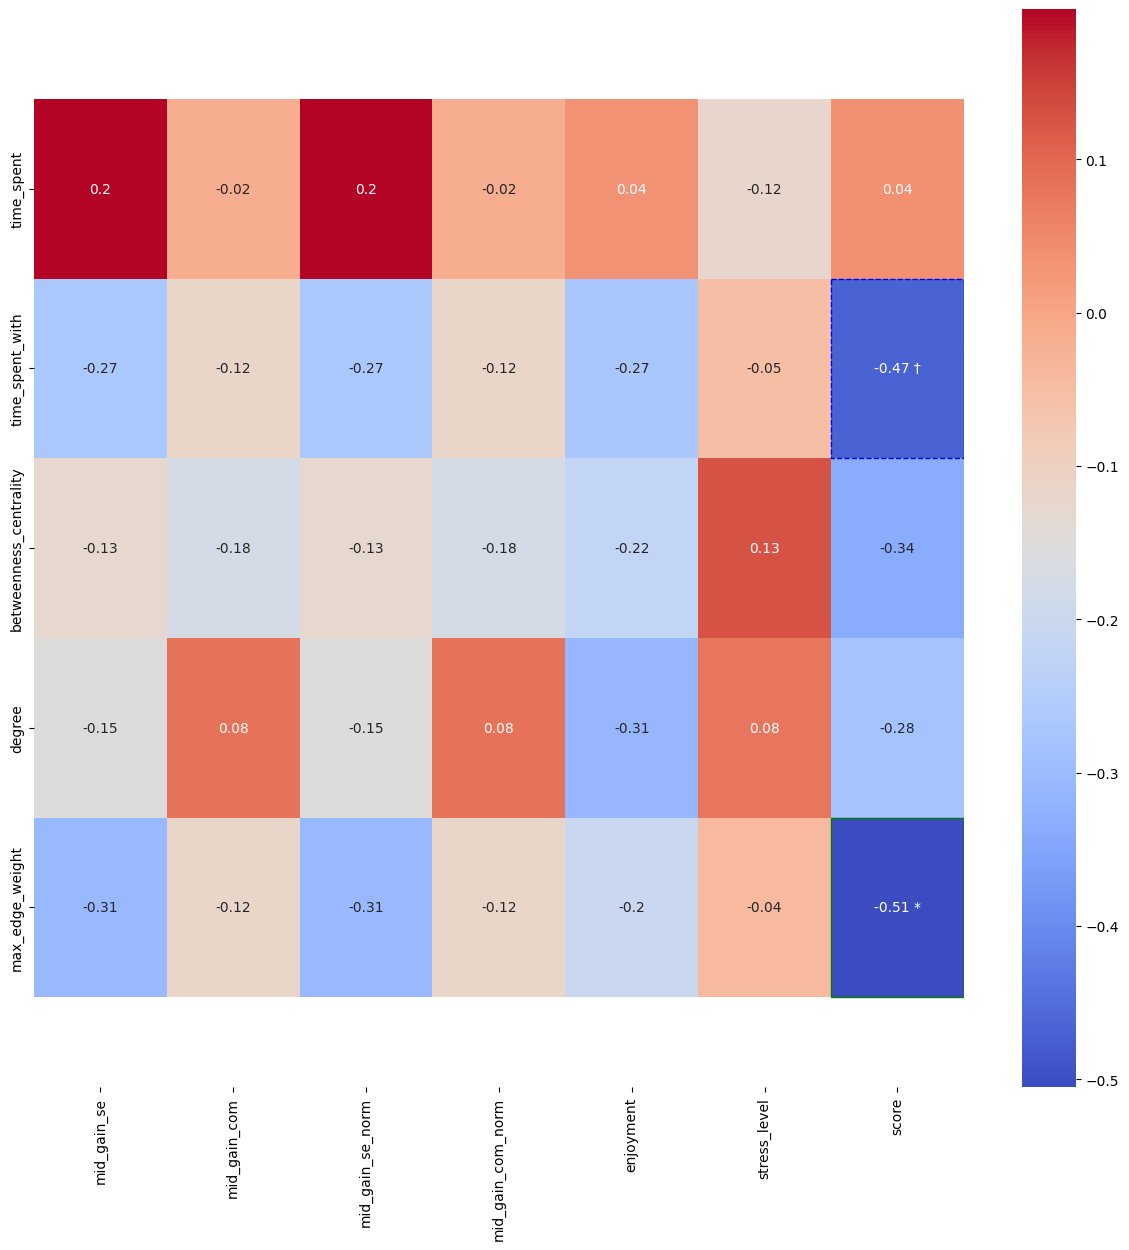

In [226]:
# define our predictors (rows) and outcomes (columns)
predictors = ['time_spent', 'time_spent_with', 'betweenness_centrality', 'degree', 'max_edge_weight']
outcomes = ['mid_gain_se', 'mid_gain_com', 'mid_gain_se_norm', 'mid_gain_com_norm', 'enjoyment','stress_level', 'score']

compute_correlation(merged_df, predictors, outcomes)

In [ ]:

#Data Analysis
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(grouped_data, create_using=Graphtype, source='person_identity', target='is_oriented_toward', edge_attr='is_with_count')
btc = nx.betweenness_centrality(G)
ln2_list = list(grouped_data['is_with_count_ln2'])
cmap = plt.get_cmap('cool')
cmap2 = plt.get_cmap('viridis')
d = dict(nx.degree(G))
nx.spring_layout(G)
nx.draw(G, node_size=[v * 10000 for v in btc.values()], cmap = cmap, vmin = min(d.values()), vmax = max(d.values()), node_color=[v for v in d.values()], edge_cmap = cmap2, edge_color = [e[2]['is_with_count'] for e in G.edges(data=True)], with_labels=True, edge_vmin = min([e[2]['is_with_count'] for e in G.edges(data=True)]), edge_vmax = max([e[2]['is_with_count'] for e in G.edges(data=True)]), width = 0.1)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in G.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in G.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')

In [ ]:
#print(nx.prominent_group(G,2))
#print(nx.prominent_group(G,3))
#print(nx.prominent_group(G,4))
#print(nx.prominent_group(G,5))

In [ ]:
#nx.second_order_centrality(G)
#nx.clustering(G, weight='counts')


In [ ]:
nx.voterank(G,8)
nx.barycenter(G, weight='is_with_count')
community_list = nx.community.louvain_communities(G, weight='is_with_count')
print(community_list)

In [ ]:
node_t_s = time_spent_dat.set_index('person_identity').to_dict()['time_spent']
#is_with_ln2 = grouped_data.set_index('is_with_count_ln2').to_dict()['person_identity', 'is_oriented_toward']

nx.set_node_attributes(G, node_t_s, 'time_spent')
print(node_t_s)
tim_sp = nx.get_node_attributes(G, 'time_spent')
for all in tim_sp:
    print(nx.get_node_attributes(G, 'time_spent')[all])

In [ ]:
def dataplot(Group):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    for all in nx.get_node_attributes(Group, 'time_spent'):
        tim_spent.append(nx.get_node_attributes(Group, 'time_spent')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    nx.spring_layout(Group)
    nx.draw(Group, node_size=[v * .003 for v in tim_spent ], cmap = cmap, vmin = min(btc.values()), vmax = max(btc.values()), node_color=[b for b in btc.values()], edge_cmap = cmap2, edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]))
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
    cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')



dataplot(G)

#G_group1 = G.subgraph(community_list[0])
#G_group2 = G.subgraph(community_list[1])
#G_group3 = G.subgraph(community_list[2])
#G_group4 = G.subgraph(community_list[3])
#G_group5 = G.subgraph(community_list[4])


In [ ]:
dataplot(G_group1)

In [ ]:
dataplot(G_group2)

In [ ]:
dataplot(G_group3)

In [ ]:
dataplot(G_group4)

In [ ]:
dataplot(G_group5)